# FBRESNET - one example

In [17]:
# Import Packages
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [18]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [19]:
# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

### Initialisation
The condition are as follows:
$a=1$ ,
$p=1$ ,
the constraint is $0 <x_i <1$ .

In [35]:
model = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(2000,50,1,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=128,
    lr=1, 
    nb_epochs=50,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=True
    )

### Dataset

In [36]:
train_set, val_set = model.CreateDataSet()

### Trainings

In [37]:
# correct order
model.train(train_set,val_set)
# reverse order
# model.train(val_set, train_set)

epoch :  0  -----  training :  0.0326    validation :  0.0267
epoch :  1  -----  training :  0.0284    validation :  0.0235
epoch :  2  -----  training :  0.0253    validation :  0.0212
epoch :  3  -----  training :  0.0231    validation :  0.0196
epoch :  4  -----  training :  0.0214    validation :  0.0185
epoch :  5  -----  training :  0.0202    validation :  0.0177
epoch :  6  -----  training :  0.0194    validation :  0.0173
epoch :  7  -----  training :  0.0189    validation :  0.0169
epoch :  8  -----  training :  0.0185    validation :  0.0167
epoch :  9  -----  training :  0.0183    validation :  0.0166
epoch : 10  -----  training :  0.0181    validation :  0.0165
epoch : 11  -----  training :  0.0180    validation :  0.0164
epoch : 12  -----  training :  0.0179    validation :  0.0164
epoch : 13  -----  training :  0.0178    validation :  0.0163
epoch : 14  -----  training :  0.0177    validation :  0.0163
epoch : 15  -----  training :  0.0177    validation :  0.0163
epoch : 

# Test the model

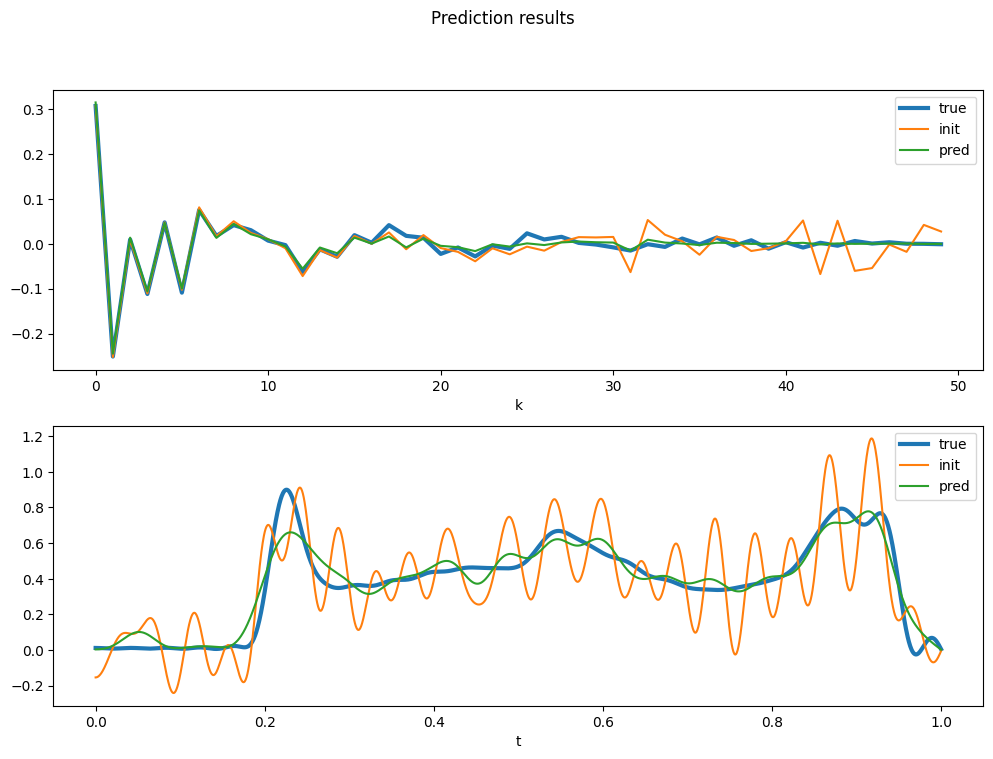

Example 12 relative error: 0.020518457517027855
Example 12 initial error: 0.16647082567214966
Erreur de sortie :  0.016252664849162102
Erreur initiale :  0.12718144059181213


In [49]:
loss, signals = model.test(val_set,plot_opt=True, idx=12)

### Test on a Gaussian function

<class 'str'>


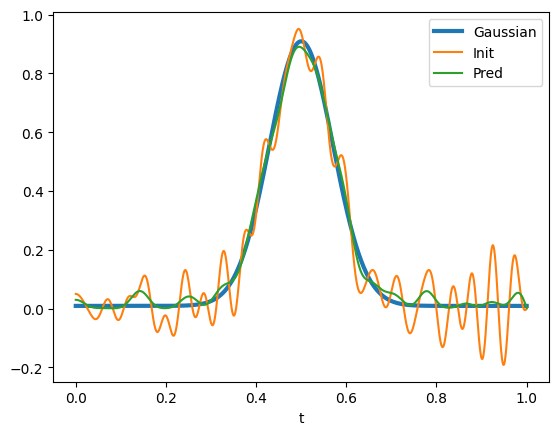

|x-xp|/|x| =  0.00418103402642758


In [50]:
model.test_gauss()

### Lipschitz constant

Here we implement for the Gaussian signal the lipschitz constant of the neural network, depending on the input. s or if 

$x_{in}=x_{bias}=T_a^T y^\delta$ 

In [51]:
model.model.Lipschitz(opt1="semi",opt2="entree11")

0.049242873072867656

$x_{in}= 0$, and $x_{bias}= T_a^T y^\delta$ 

In [52]:
model.model.Lipschitz(opt1="semi",opt2="entree01")

0.0001278535326365203

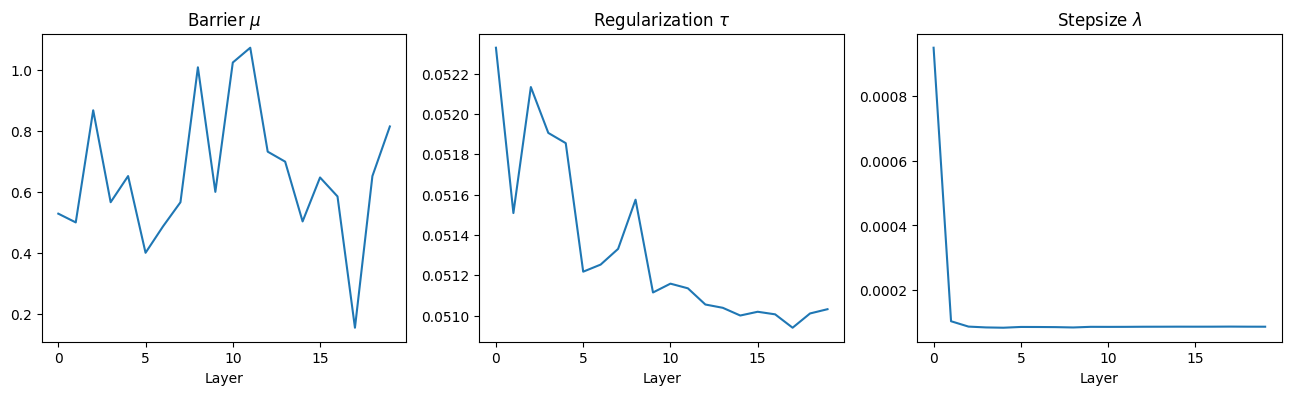

In [53]:
mu_vec = [np.squeeze(model.model.Layers[layer_id].mu).item() for layer_id in range(20)]
tau_vec = [np.squeeze(model.model.Layers[layer_id].gamma_reg[1]).item() for layer_id in range(20)]
lambda_vec = [np.squeeze(model.model.Layers[layer_id].gamma_reg[0]).item() for layer_id in range(20)]

im, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(mu_vec)
ax[0].set_xlabel('Layer')
ax[0].set_title(r'Barrier $\mu$')

ax[1].plot(tau_vec)
ax[1].set_xlabel('Layer')
ax[1].set_title(r'Regularization $\tau$')

ax[2].plot(lambda_vec)
ax[2].set_xlabel('Layer')
ax[2].set_title(r'Stepsize $\lambda$')
plt.show()


In [54]:
opt_hist = np.load('../outputs/opt_hist/model_000_opt_hist.npy', allow_pickle=True)[()]
opt_hist.keys()

dict_keys(['lipschitz', 'loss_train', 'loss_val', 'fb_params'])

In [55]:
hyper_params = opt_hist['fb_params']

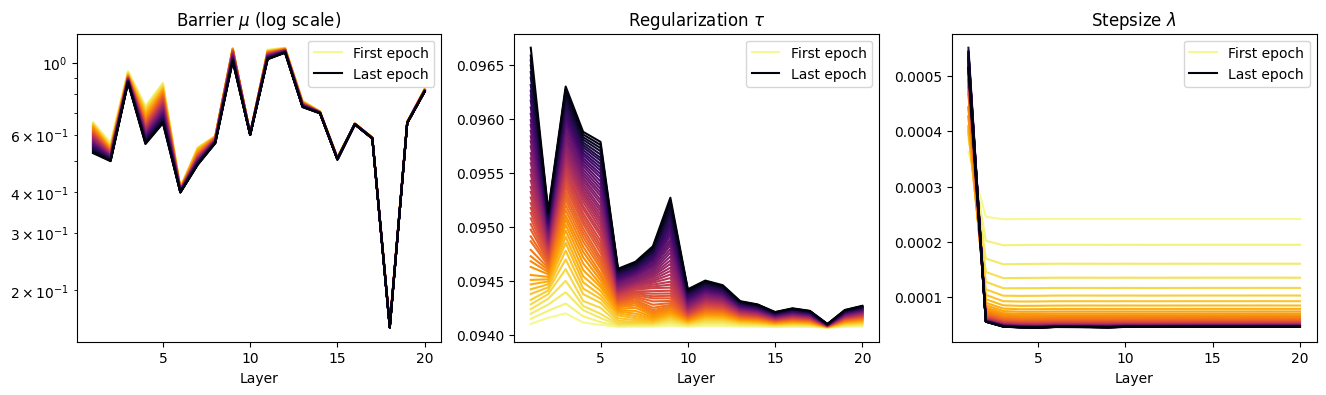

In [56]:
im, ax = plt.subplots(1,3, figsize=(16,4))
for i in range(model.nb_epochs):

    ax[0].plot(np.arange(1, model.nb_blocks+1),hyper_params[i,0], color=sns.color_palette('inferno',n_colors=model.nb_epochs)[model.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(model.nb_epochs-1) else '_hide')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Layer')
    ax[0].set_title(r'Barrier $\mu$ (log scale)')

    ax[1].plot(np.arange(1, model.nb_blocks+1),hyper_params[i,1], color=sns.color_palette('inferno',n_colors=model.nb_epochs)[model.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(model.nb_epochs-1) else '_hide')
    ax[1].set_xlabel('Layer')
    ax[1].set_title(r'Regularization $\tau$')

    ax[2].plot(np.arange(1, model.nb_blocks+1),hyper_params[i,2], color=sns.color_palette('inferno',n_colors=model.nb_epochs)[model.nb_epochs-i-1],
        label='First epoch' if i==0 else 'Last epoch' if i==(model.nb_epochs-1) else '_hide')
    ax[2].set_xlabel('Layer')
    ax[2].set_title(r'Stepsize $\lambda$')

for i in range(3): ax[i].legend()
plt.show()

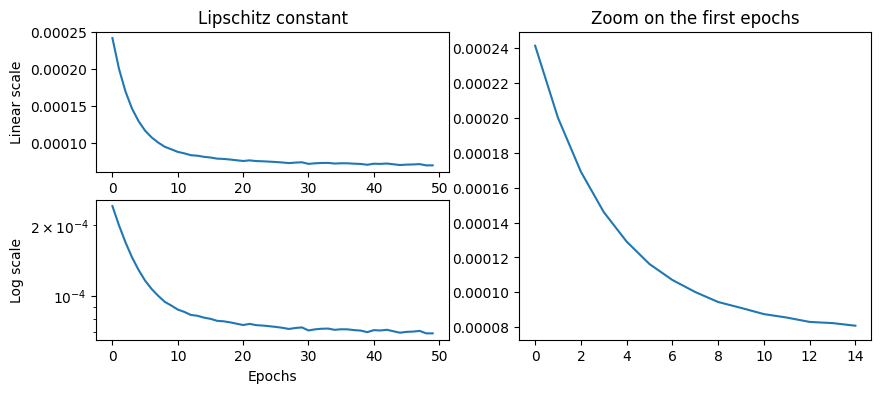

In [57]:
lip_cte = opt_hist['lipschitz']

fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(2,2,1)
ax.plot(lip_cte)
ax.set_ylabel('Linear scale')
ax.set_title('Lipschitz constant')
#ax.set_xticks(np.arange(1,exp1.nb_epochs+1,3))

ax = fig.add_subplot(2,2,3)
ax.plot(lip_cte)
ax.set_xlabel('Epochs')
ax.set_ylabel('Log scale')
ax.set_yscale('log')
#ax.set_xticks(np.arange(1,exp1.nb_epochs+1,3))

ax = fig.add_subplot(2,2,(2,4))
ax.plot(lip_cte[:15])
ax.set_title('Zoom on the first epochs')
#ax.set_xticks(np.arange(1,16,3))

plt.show()